# Data Science Case Study

When listing a car, a host has the opportunity to set its daily price. In this process, the company recommends a price (which the host may accept or ignore) that is designed to optimize the host’s revenue, given various properties of the listing.

1. Based on the data found in `vehicles_booking_history.csv`, produce a well-written function that accepts properties of a listing and returns a daily price that is designed to improve/optimize revenue. Here is a dictionary for the data in the .csv:
 * `vehicle_id` - vehicle's unique ID
 * `date` - calendar date
 * `is_booked` - 1 if the listing is booked
 * `tmv` - true market value of vehicle
 * `category_aggregate` - vehicle category group
 * `demand_supply_ratio` - daily demand (web and app sessions) over supply (count of live listings in the local market, e.g. a city)
 * `price` - vehicle's listed price as of the given date

2. Assuming your function is deployed in production, describe metrics and methods to gauge the success of your recomendations. 

We’re looking for a compelling process of analysis/modeling, organized and intuitive production-level code (for the function itself, as though it were part of a REST API implementation), and thoughtful consideration of measuring business impact.

Feel free to reach out with any questions!

## Analysis, Modeling, Math, etc.

(Import the data and do analysis/modeling/math or whatever, starting here.)

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.metrics import mean_squared_error
import math
from datetime import datetime
%matplotlib inline

df = pd.read_csv("vehicles_booking_history.csv")
df['weekday'] = pd.to_datetime(df.date).dt.day_name()
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


In [252]:
df.category_grouped.value_counts()

suv        687
midsize    634
compact    421
upscale     80
van         68
Name: category_grouped, dtype: int64

### Analysis of Dataset        
First we will have a look at the whole data by each variable and then breakdown to understand it more.     

#### Distribution of price by Weekday         
We see a right tailed distribution in the distribution plot. We also see that box plot almost have the same median for ever weekday with some outliers on the higher end

Text(0.5,1,'Distribution analysis by weekday')

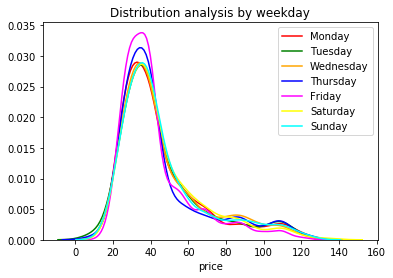

In [253]:
sns.distplot(df[df.weekday=='Monday'].price, hist=False, color='red', label='Monday')
sns.distplot(df[df.weekday=='Tuesday'].price, hist=False, color='green', label='Tuesday')
sns.distplot(df[df.weekday=='Wednesday'].price, hist=False, color='orange', label='Wednesday')
sns.distplot(df[df.weekday=='Thursday'].price, hist=False, color='blue', label='Thursday')
sns.distplot(df[df.weekday=='Friday'].price, hist=False, color='magenta', label='Friday')
sns.distplot(df[df.weekday=='Saturday'].price, hist=False, color='yellow', label='Saturday')
sns.distplot(df[df.weekday=='Sunday'].price, hist=False, color='cyan', label='Sunday')
plt.title('Distribution analysis by weekday')

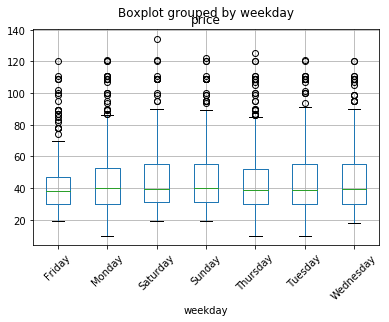

In [254]:
df.boxplot(column='price', by='weekday', rot=45)

#### Distribution of price by Booking         
We see that a vehicle tends to remain unbooked when price is higher as distribution of not booked lies on the higher end for some price range

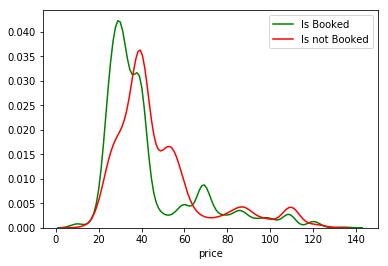

In [255]:
sns.distplot(df[df.is_booked==1].price, hist=False, color='green', label='Is Booked')
sns.distplot(df[df.is_booked==0].price, hist=False, color='red', label='Is not Booked')

#### Distribution of price by category of vehicle         
As expected we see that the price is different for different vehicles

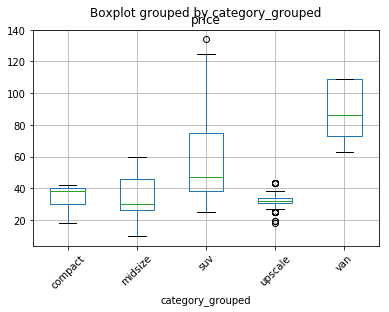

In [256]:
df.boxplot(column='price', by='category_grouped', rot=45)

#### Price analysis for SUV         
Lets analyze for vehicle category SUV.    
 - A right tailed distribution by weekday indicating some weekdays have higher price vs Friday which has price on the lower side     
 - as seen above the price of unbooked SUV tends to be on the higher side    
 - The box plots show difference in prices by weekday Friday being the lowest
 


In [257]:
dfSuv = df[df.category_grouped=='suv']
dfSuv.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
5,508104,2019-02-19,1,5148,suv,4.303872,38.0,Tuesday
9,405192,2018-09-05,0,18802,suv,0.890217,60.0,Wednesday
11,406331,2018-11-10,0,39102,suv,5.671775,87.0,Saturday
13,406331,2018-11-20,0,39102,suv,5.412565,87.0,Tuesday


Text(0.5,1,'Distribution analysis by weekday for SUV')

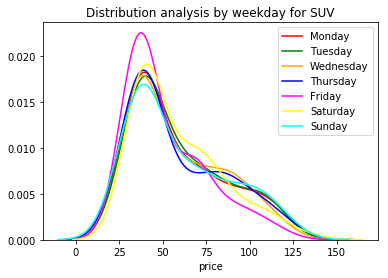

In [258]:
sns.distplot(dfSuv[dfSuv.weekday=='Monday'].price, hist=False, color='red', label='Monday')
sns.distplot(dfSuv[dfSuv.weekday=='Tuesday'].price, hist=False, color='green', label='Tuesday')
sns.distplot(dfSuv[dfSuv.weekday=='Wednesday'].price, hist=False, color='orange', label='Wednesday')
sns.distplot(dfSuv[dfSuv.weekday=='Thursday'].price, hist=False, color='blue', label='Thursday')
sns.distplot(dfSuv[dfSuv.weekday=='Friday'].price, hist=False, color='magenta', label='Friday')
sns.distplot(dfSuv[dfSuv.weekday=='Saturday'].price, hist=False, color='yellow', label='Saturday')
sns.distplot(dfSuv[dfSuv.weekday=='Sunday'].price, hist=False, color='cyan', label='Sunday')
plt.title('Distribution analysis by weekday for SUV')

Text(0.5,1,'Distribution analysis by Booking for SUV')

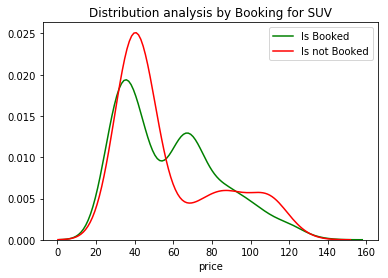

In [259]:
sns.distplot(dfSuv[dfSuv.is_booked==1].price, hist=False, color='green', label='Is Booked')
sns.distplot(dfSuv[dfSuv.is_booked==0].price, hist=False, color='red', label='Is not Booked')
plt.title('Distribution analysis by Booking for SUV')

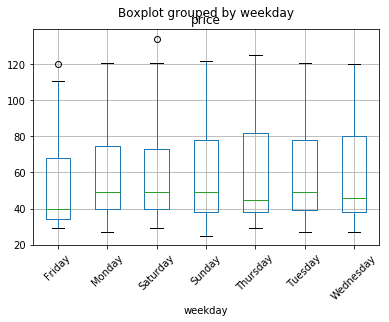

In [260]:
dfSuv.boxplot(column='price', by='weekday', rot=45)

In [261]:
groupedDF = df.groupby(['category_grouped', 'weekday'])
meanDF = groupedDF.mean()[['price']].reset_index()#.median()[['price']]
print(meanDF.head())
medianDF = groupedDF.median()[['price']].reset_index()
print(medianDF.head())

  category_grouped   weekday      price
0          compact    Friday  35.044776
1          compact    Monday  34.103448
2          compact  Saturday  35.100000
3          compact    Sunday  35.277778
4          compact  Thursday  33.923077
  category_grouped   weekday  price
0          compact    Friday   38.0
1          compact    Monday   37.0
2          compact  Saturday   38.5
3          compact    Sunday   39.0
4          compact  Thursday   36.0


#### Comparative Price analysis by category and weekday
I have created a heatmap to compare mean(first heatmap)of price of category by weekday. The values are zero mean normalized(by row) for the sake of comparison of prices by category.    
- The high and low prices for different category vehicles are different, indicating that not all vehicles have peak prices on the same weekday.     
- I assumed that price would be high(assuming high price = high demand) on the weekends as people might use the vehicles for a getaway, it clearly indicates that different vehicles are used for different purposes for example vans have high prices on Thursdays and Fridays whereas upscale vehicles have higher price on Monday and compact vehicles have higher price on Tuesday.    
- We can say that Vans are used for weekend getaways, whereas upscale and compact vehicles are used for meetings or going to offices, but the price of the upscale and compacts fall in the week so we cannot say for sure about these cars.


Text(0.5,1,'Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

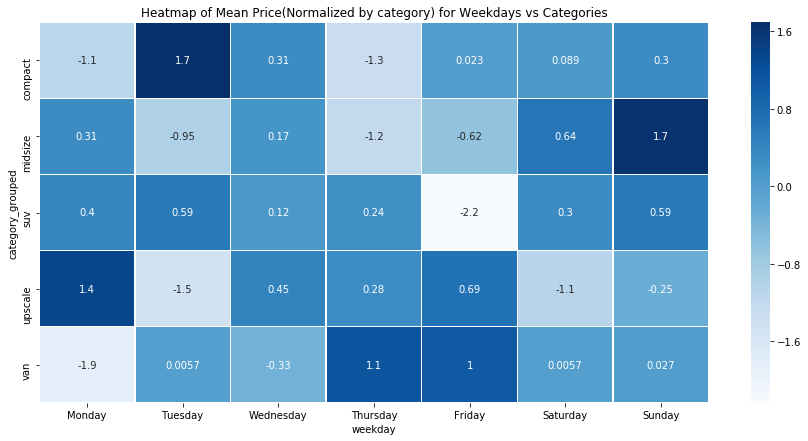

In [262]:
pivotedMean = meanDF.pivot(index='category_grouped', columns='weekday', values='price')
#zero mean normalization
# 1: substract mean
dfNorm = pivotedMean.sub(pivotedMean.mean(axis=1), axis=0)
# 2: divide by standard dev
dfNorm = dfNorm.div( pivotedMean.std(axis=1), axis=0)
# Re-ordering columns
dfNorm = dfNorm[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']]

fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(dfNorm, annot=True, linewidths=.5, cmap="Blues")
ax.set_title('Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

#### Comparative Price analysis by Vehicle and weekday
As there were limited number of vehicles I created a similar heatmap as above for them, no values for few vehicle ids mean that they have the same mean value throughout the week(eg: vehicle id: 289235)    

Here also we see the similar trend that the vehicle price is not uniform throughout the week

Text(0.5,1,'Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

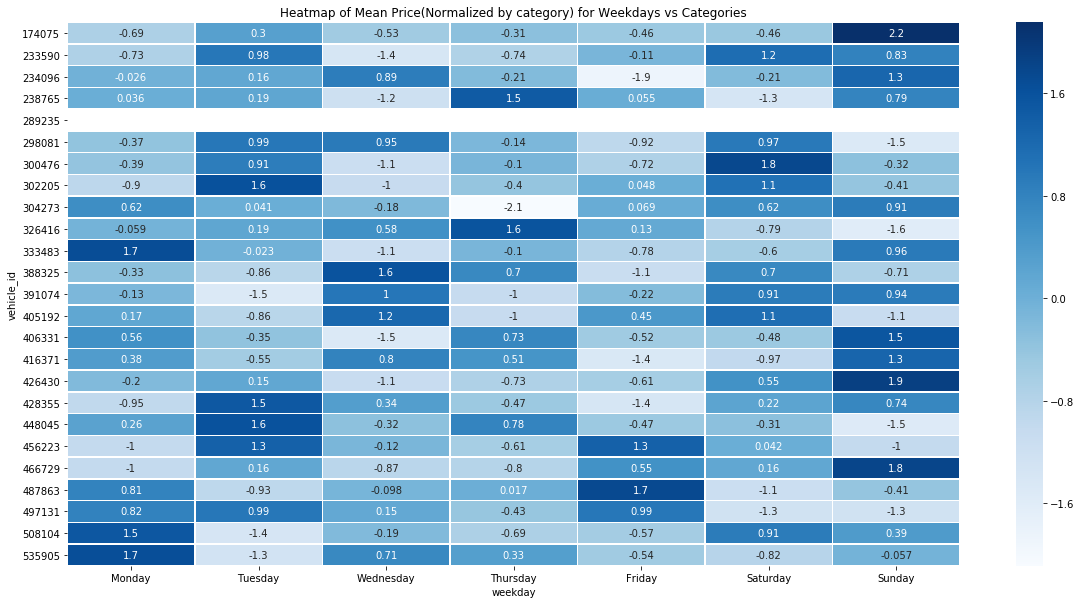

In [263]:
groupedDF = df.groupby(['vehicle_id', 'weekday'])
meanDF = groupedDF.mean()[['price']].reset_index()

pivotedVehicle = meanDF.pivot(index='vehicle_id', columns='weekday', values='price')
# 1: substract mean
dfNorm = pivotedVehicle.sub(pivotedVehicle.mean(axis=1), axis=0)
# 2: divide by standard dev
dfNorm = dfNorm.div(pivotedVehicle.std(axis=1), axis=0 )
# Re-ordering columns
dfNorm = dfNorm[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday']]
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(dfNorm, annot=True, linewidths=.5, cmap="Blues")
ax.set_title('Heatmap of Mean Price(Normalized by category) for Weekdays vs Categories')

#### Scatter plot of numerical features
From the below scatter plot matrix we see that there is some sort of positive correlation between tmv(true market value) and price which completely makes sense as higher the cost of the vehicle higher is its price.    
Whereas I also expected the demand supply ratio to be positively co-related to price as the demand to supply ratio increase the price should increase but we do not see a clear indication in this scatter plot, which can be confirmed from below correlation matrix.

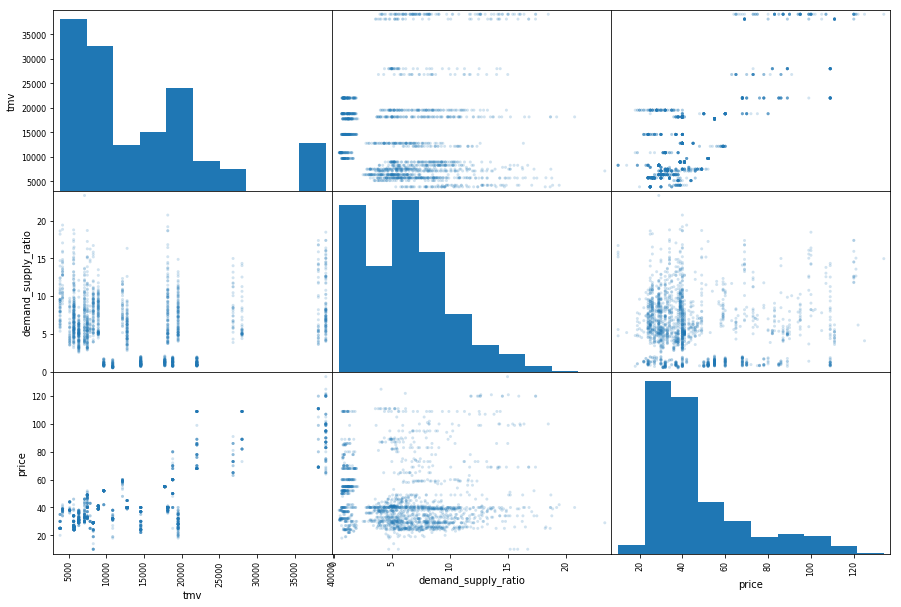

In [264]:
dfNumeric = df[['tmv','demand_supply_ratio', 'price']]
ax = pd.plotting.scatter_matrix(dfNumeric, alpha=0.2, figsize=(15, 10))

In [265]:

dfNumeric.corr(method ='pearson')

,tmv,demand_supply_ratio,price
tmv,1.000000,-0.013403,0.784662
demand_supply_ratio,-0.013403,1.000000,-0.047594
price,0.784662,-0.047594,1.000000


In [266]:
dfNumeric.corr(method ='kendall')

,tmv,demand_supply_ratio,price
tmv,1.000000,-0.137334,0.463586
demand_supply_ratio,-0.137334,1.000000,-0.105607
price,0.463586,-0.105607,1.000000


#### Scatter plot of price vs tmv categorized by vehicle category
From the below scatter plot we see that the vehicle category with same tmv(multiple records of vehicles for different date) have different price and understandably so.


Text(0.5,1,'Scatter plot of price vs tmv categorized by vehicle category')

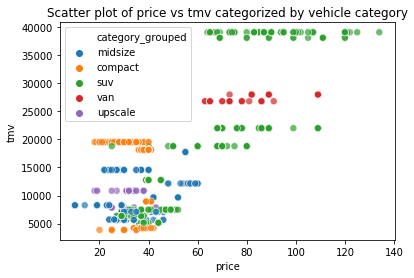

In [267]:
sns.scatterplot('price', 'tmv', data=df, hue='category_grouped', s=50, alpha=0.7)
plt.title('Scatter plot of price vs tmv categorized by vehicle category')

#### Scatter plot of price vs demand suply ratio categorized by vehicle category and booking

In this scatter plot the categories of vehicles are categorized by colors and booking is indicated by different markers, cross indicates booking and circle indicates no booking as shown in the legends.    

We can observe that when there is higher demand supply ratio there are more bookings.    
We also see that higher demand supply ratio does not indicate high price(We can use this to maximize the profit). 


Text(0.5,1,'Scatter plot of price vs demand suply ratio categorized by vehicle category and booking')

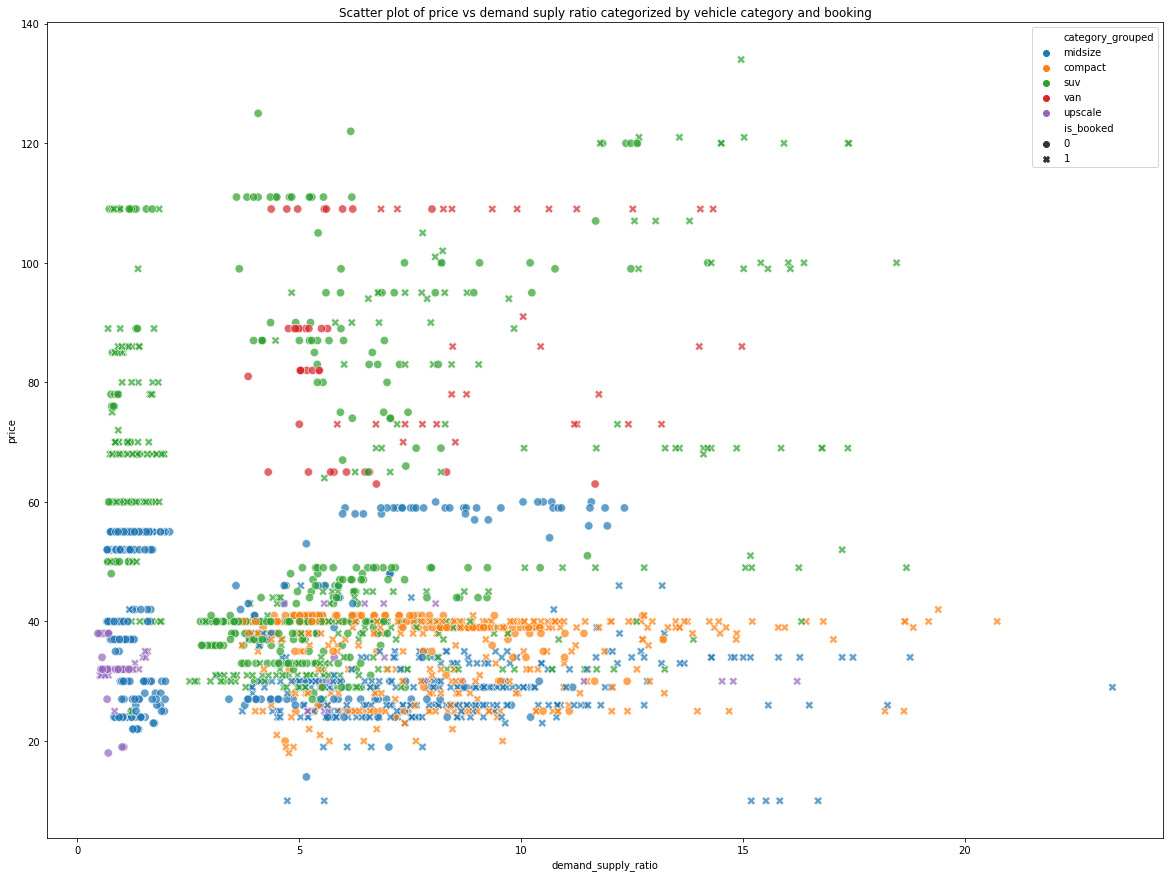

In [268]:
# dfNumeric.plot.scatter(x='price', y='demand_supply_ratio', c='category_grouped')
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot('demand_supply_ratio', 'price', data=df, hue='category_grouped', style="is_booked", s=70, alpha=0.7)
plt.title('Scatter plot of price vs demand suply ratio categorized by vehicle category and booking')

From the above two scatter plots we can conclude that     
- Higher the TMV(Market Value) higher the price.       
- Higher Demand Supply Ratio does not account to higher Price.    
- Higher Demand Supply Ratio means high probability of getting booked.    

We can use this observations to optimize the price.     


### Steps for Price Optimization
The price field in the dataset is the listed price and it is not necessarily the optimum price and to maximize the profit we need all the vehicles to be booked and very less should be left unbooked. How can we acheive that?

- First Train a classifier(will use Logistic Regression any can be used) to check whether the vehicle would be booked or not on the given dataset.     
- As per general knowledge and the scatter plot above, the demand-supply ratio should have a positive impact(i.e. having positive weight) and there would be a price threshold till which the vehicle will be booked hence to get that price will do the following steps.    
    - If the vehicle is not booked try and reduce the price till it is booked(using classifier) and store this new price information.
    - If the vehicle is booked try and increase the price till it stays booked(using classifier) and store this new price.
- Then we will use this new price to train a Regression algorithm(Linear regression in this case but any can be used) so that we have learned the optimal price for profit maximization. The Regression model will estimate       <b>E(price|vehicle=booked)</b>
- Use this Linear Regression to get the price and continue getting new data everyday to further improve the optimum price information or may be by using online learning whenever a vehicle is booked.

### Apply Logistic Regression     

In [269]:
#Slightly Unbalanced data set
df.is_booked.value_counts()

1    1016
0     874
Name: is_booked, dtype: int64

In [270]:
# Create dummy values for categorical variables
categoryDummies = pd.get_dummies(df.category_grouped,prefix='category')
print(categoryDummies.head())
weekdayDummies = pd.get_dummies(df.weekday,prefix='weekdays')
print(weekdayDummies.head())

   category_compact  category_midsize  category_suv  category_upscale  \
0                 0                 1             0                 0   
1                 1                 0             0                 0   
2                 0                 1             0                 0   
3                 0                 0             1                 0   
4                 0                 1             0                 0   

   category_van  
0             0  
1             0  
2             0  
3             0  
4             0  
   weekdays_Friday  weekdays_Monday  weekdays_Saturday  weekdays_Sunday  \
0                1                0                  0                0   
1                0                0                  1                0   
2                0                0                  1                0   
3                0                1                  0                0   
4                0                0                  0                0   

  

In [271]:
preparedDf = pd.concat([df, categoryDummies, weekdayDummies], axis=1)
preparedDf = preparedDf.drop(['vehicle_id', 'date', 'weekday'], axis=1)
preparedDf.head()

,is_booked,tmv,category_grouped,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
0,0,14569,midsize,1.902318,30.0,0,1,0,0,0,1,0,0,0,0,0,0
1,1,4201,compact,14.622831,39.0,1,0,0,0,0,0,0,1,0,0,0,0
2,1,5724,midsize,8.659708,24.0,0,1,0,0,0,0,0,1,0,0,0,0
3,1,39102,suv,13.570390,121.0,0,0,1,0,0,0,1,0,0,0,0,0
4,0,9666,midsize,1.297453,42.0,0,1,0,0,0,0,0,0,0,1,0,0


In [272]:
Y = preparedDf.is_booked
X = preparedDf.drop(['is_booked'], axis=1)
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.3, random_state = 11)
trainCategory = xTrain.category_grouped
xTrain = xTrain.drop(['category_grouped'], axis=1)
xTest = xTest.drop(['category_grouped'], axis=1)

In [273]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logistic = LogisticRegression(solver='liblinear')
logistic.fit(xTrain,yTrain)

# prediction on Test Data
yPred=logistic.predict(xTest)

# prediction on Train Data
yPredTrain=logistic.predict(xTrain)

Text(0.5,257.44,'Predicted label')

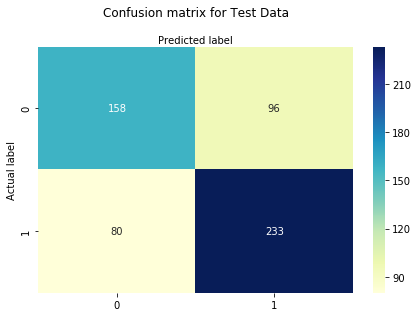

In [274]:
cnf_matrix = metrics.confusion_matrix(yTest, yPred)
class_names = logistic.classes_ # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5,257.44,'Predicted label')

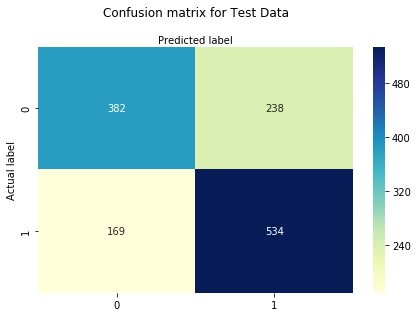

In [275]:
cnf_matrix = metrics.confusion_matrix(yTrain, yPredTrain)
class_names = logistic.classes_ # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix for Test Data', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [276]:
print ('Accuracy on Training Data :', metrics.accuracy_score(yTrain, yPredTrain))
print ('Accuracy on Test Data :', metrics.accuracy_score(yTest, yPred))

Accuracy on Training Data : 0.6923658352229781
Accuracy on Test Data : 0.689594356261023


In [277]:
print(metrics.classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.66      0.62      0.64       254
           1       0.71      0.74      0.73       313

    accuracy                           0.69       567
   macro avg       0.69      0.68      0.68       567
weighted avg       0.69      0.69      0.69       567



In [278]:
print('Feature Vector: ',X.columns)
print('corresponding weights: ',logistic.coef_[0])

Feature Vector:  Index(['tmv', 'category_grouped', 'demand_supply_ratio', 'price',
       'category_compact', 'category_midsize', 'category_suv',
       'category_upscale', 'category_van', 'weekdays_Friday',
       'weekdays_Monday', 'weekdays_Saturday', 'weekdays_Sunday',
       'weekdays_Thursday', 'weekdays_Tuesday', 'weekdays_Wednesday'],
      dtype='object')
corresponding weights:  [ 5.94807054e-05  2.36426520e-01 -4.11779844e-02 -2.94371181e-01
 -2.49808695e-01  4.20697866e-01  4.60711697e-02 -1.53253457e-01
 -4.05583374e-01 -1.42638223e-02  1.64926470e-02  9.59733493e-02
  5.70241946e-02  1.95639221e-02  1.28785612e-04]


In [279]:
print('weight of demand_supply ratio : ',logistic.coef_[0][1])
print('weight of tmv : ',logistic.coef_[0][0])
print('weight of price : ',logistic.coef_[0][2])

weight of demand_supply ratio :  0.23642651994959152
weight of tmv :  5.948070535432155e-05
weight of price :  -0.041177984436829775


We see that the weight of Demand supply ratio is 0.24 which means higher the ratio higher the probability of getting booked     

#### Get optimal price using classification model       
Though the above Logistic regression model still requires some tuning, but due to shortage of time lets consider that it is a very good model and try to get the optimal price to maximize the profit. We will use that same test and train data to show the increase in profit.

In [280]:
trainData = pd.concat([xTrain, yTrain], axis=1)
testData = pd.concat([xTest, yTest], axis=1)
testData.head()

,tmv,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday,is_booked
74,5669,6.712912,27.0,0,1,0,0,0,0,0,0,0,1,0,0,0
1758,22008,1.243208,68.0,0,0,1,0,0,0,0,0,0,0,1,0,1
770,19525,11.076199,26.0,1,0,0,0,0,1,0,0,0,0,0,0,1
983,5148,4.140639,44.0,0,0,1,0,0,0,0,0,0,0,0,1,0
1545,8275,6.083003,19.0,0,1,0,0,0,0,1,0,0,0,0,0,1


In [281]:
trainData['predictedBooking'] = logistic.predict(xTrain)
testData['predictedBooking'] = logistic.predict(xTest)
testData.head()

,tmv,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday,is_booked,predictedBooking
74,5669,6.712912,27.0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
1758,22008,1.243208,68.0,0,0,1,0,0,0,0,0,0,0,1,0,1,0
770,19525,11.076199,26.0,1,0,0,0,0,1,0,0,0,0,0,0,1,1
983,5148,4.140639,44.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1545,8275,6.083003,19.0,0,1,0,0,0,0,1,0,0,0,0,0,1,1


In [282]:
# Code for increasing or decreasing the price
threshold = 50 #Price threshold to increase or decrease in $
newPrice = []
newBooking = []
for index, row in trainData.iterrows():
    row = row.drop(labels=['is_booked']) # Assuming predicted value is right 
    if row['predictedBooking'] == 1: # if prediction label is 1 try to increase price
        row = row.drop(labels=['predictedBooking'])
        predicted = 1
        i = 0
        while(predicted == 1 and i<threshold):
            row['price'] += 1
            predicted = logistic.predict([row])[0]
            i += 1
        if predicted == 1: #if predicted value does not change keep the price
            newPrice.append(row['price'])
            newBooking.append(predicted)
        else: #if predicted value changes to 0 keep the last value of price
            newPrice.append(row['price']-1)
            newBooking.append(1)
    else: # if prediction label is 0 try to decrease price to make booking
        row = row.drop(labels=['predictedBooking'])
        predicted = 0
        i = 0
        while(predicted == 0 and i<threshold and row['price']>5):
#             print(row)
            row['price'] -= 1 #reduce price
            predicted = logistic.predict([row])[0]
            i += 1
#             print(row['price'])
#             print(predicted)
        if predicted == 0: #if predicted value does not change keep the price
            newPrice.append(row['price'])
            newBooking.append(predicted)
        else: #if predicted value changes to 1 keep the last value of price
            newPrice.append(row['price']+1)
            newBooking.append(1)
            
        

In [305]:
trainData['newPrice'] = newPrice
trainData['newLabel'] = newBooking
trainData.head()

,tmv,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday,newPrice,newLabel
531,22008,1.466096,47.0,0,0,1,0,0,0,0,0,0,1,0,0,47.0,1
819,27993,5.171116,61.0,0,0,0,0,1,0,0,0,0,0,0,1,61.0,1
750,22008,0.951813,59.0,0,0,1,0,0,0,0,1,0,0,0,0,59.0,0
177,39102,5.979250,95.0,0,0,1,0,0,0,1,0,0,0,0,0,95.0,1
867,39102,8.067818,97.0,0,0,1,0,0,1,0,0,0,0,0,0,97.0,1


Text(0.5,1,'Scatter plot of price vs demand suply ratio categorized by vehicle category and booking after Optimization')

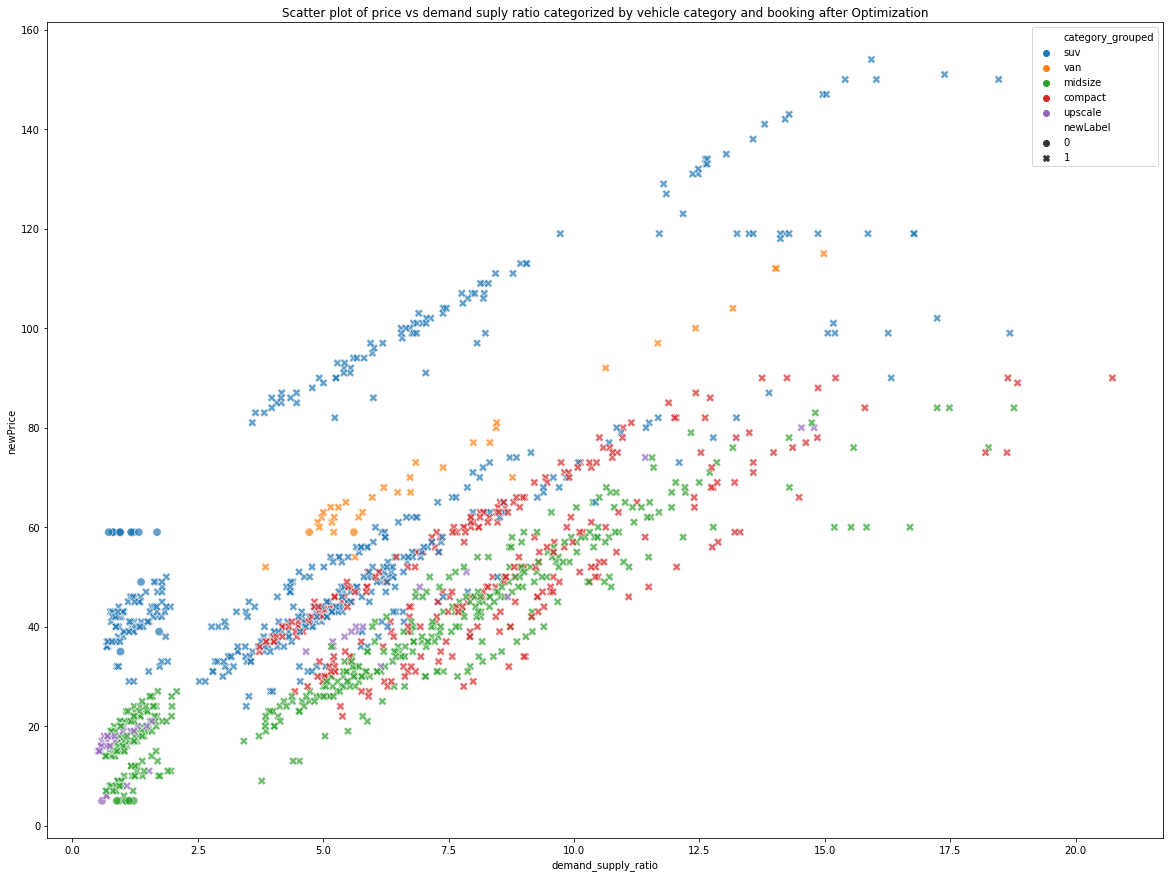

In [284]:
# dfNumeric.plot.scatter(x='price', y='demand_supply_ratio', c='category_grouped')
trainData['category_grouped'] = trainCategory
fig, ax = plt.subplots(figsize=(20,15))
sns.scatterplot('demand_supply_ratio', 'newPrice', data=trainData, hue='category_grouped', style="newLabel", s=70, alpha=0.7)
plt.title('Scatter plot of price vs demand suply ratio categorized by vehicle category and booking after Optimization')

Here we can observe that there is a positive correlation between new price which we get by using the classifier model.   
We also see that class of the vehicle also plays an important role in determining the price, hence by manually we can find an ideal ratio between the price and demand supply ratio for different class of vehicles and use that to predict price.    
However in ideal case price might not only be affected by demand and supply, various other factors like holiday, an local event in the city and inflation etc. might affect it

In [287]:
# bring test and train data in same format for training regression
print('Revenue without optimization for Test Data: ', sum(testData.is_booked*testData.price))
trainData.price = trainData.newPrice #use new Price as the real value to predict 
trainData = trainData.drop(['category_grouped', 'is_booked', 'newLabel', 'newPrice', 'predictedBooking' ], axis=1)
testData = testData.drop(['is_booked', 'predictedBooking'], axis=1)
# trainData.head()


Revenue without optimization for Test Data:  14054.0


In [288]:
testData.head()

,tmv,demand_supply_ratio,price,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
74,5669,6.712912,27.0,0,1,0,0,0,0,0,0,0,1,0,0
1758,22008,1.243208,68.0,0,0,1,0,0,0,0,0,0,0,1,0
770,19525,11.076199,26.0,1,0,0,0,0,1,0,0,0,0,0,0
983,5148,4.140639,44.0,0,0,1,0,0,0,0,0,0,0,0,1
1545,8275,6.083003,19.0,0,1,0,0,0,0,1,0,0,0,0,0


### Apply Linear Regression         
As we want to formulate a function to get the price based on the variables we have, we can use a simple linear regression as we can learn the weights for every feature and calculate the price as shown below.    

<b>E(Price|vehicle=booked) = W<sub>0</sub> + W<sub>1</sub> (X<sub>1</sub>) + W<sub>2</sub> (X<sub>2</sub>) + W<sub>3</sub> (X<sub>3</sub>) + ... </b>   

W<sub>0</sub> is the bias term or intercept    
W<sub>1</sub>,...,W<sub>n</sub> are the model parameters or weights     
X<sub>1</sub>,...,X<sub>n</sub> are feature values     

As we saw before there was no collinearity in the numerical predictor variable in the correlation matrix before, hence they are linearly independent. However this does not affect the predictive power but individual predictor variable’s impact on the response variable could be calculated wrongly.    
I will do one hot encoding for category of vehicles and extracted weekday from the date.     


In [289]:
yTrain = trainData.price
xTrain = trainData.drop(['price'], axis=1)
yTest = testData.price
xTest = testData.drop(['price'], axis=1)

In [290]:
linearRegressor = LinearRegression()
linearRegressor.fit(xTrain, yTrain)
yPrediction = linearRegressor.predict(xTest)
yPredictionTrain = linearRegressor.predict(xTrain)

print("Coeff of Determination score for Training Dataset = ",linearRegressor.score(xTrain, yTrain))
# print("Coeff of Determination score for Test Dataset = ",linearRegressor.score(xTest, yTest))

# print("RMSE for Test Data = ",math.sqrt(mean_squared_error(yTest, yPrediction)))
print("RMSE for Training Data = ",math.sqrt(mean_squared_error(yTrain, yPredictionTrain)))

Coeff of Determination score for Training Dataset =  0.9831408280871538
RMSE for Training Data =  3.3558222772705637


In [291]:
linearRegressor.coef_

array([ 1.40602998e-03,  5.15996349e+00, -5.40651916e+00, -5.37858620e+00,
        1.10669825e+01,  2.96955313e-01, -5.78832488e-01, -8.30986535e+00,
        4.55287574e-01,  1.18342278e+00,  3.26844754e+00,  1.92220077e+00,
        9.09487345e-01,  5.71019354e-01])

#### Analysis of prediction
we see that coefficient of determination or R<sup>2</sup> values for test and train dataset indicate that about 70% of variance in the dependent variable can be collectively explained by independent variables. However the RMSE(Root Mean Squared Error) is around 11.5       

From the below scattered plot we see that there are some higer values in price(or possible outliers) which are not predicted well.     
If given more time I could increase the models prediction power by doing proper outlier analysis and removing them, using various transformations to transform the data and using regularization techniques to generalize the model(it still seems to have generalized).     

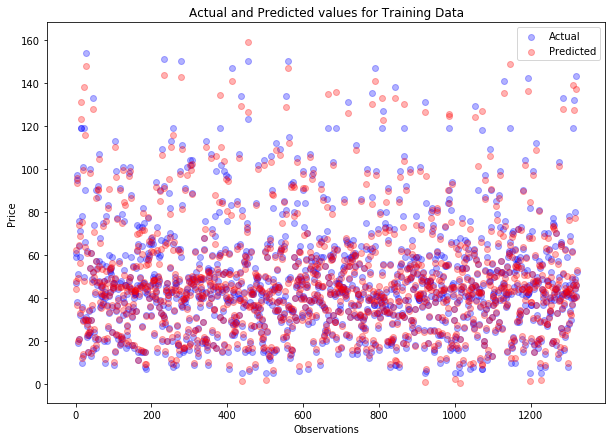

In [292]:
_, ax = plt.subplots(figsize=(10,7))
ax.scatter(x = range(0, yTrain.size), y=yTrain, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, yPredictionTrain.size), y=yPredictionTrain, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and Predicted values for Training Data')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

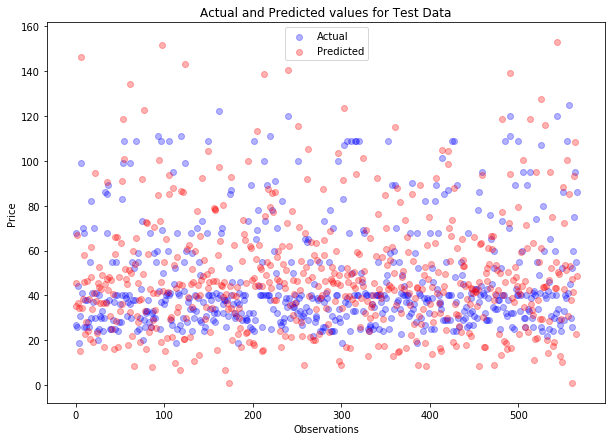

In [293]:
_, ax = plt.subplots(figsize=(10,7))
ax.scatter(x = range(0, yTest.size), y=yTest, c = 'blue', label = 'Actual', alpha = 0.3)
ax.scatter(x = range(0, yPrediction.size), y=yPrediction, c = 'red', label = 'Predicted', alpha = 0.3)
plt.title('Actual and Predicted values for Test Data')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()

As expected in training data the prediction of price is far better than that of test data as we did calculate the price from the classifier. we can see that predicted price is also higher and lower to get them booked and maximize the profit

#### Residual analysis        
In the below figures we see residuals have an approximate normal distribution with very less variance which indicates that the regression has fitted well       
   

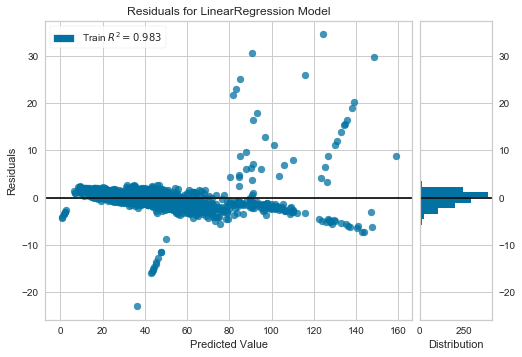

In [297]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(linearRegressor)
visualizer.fit(xTrain, yTrain)  # Fit the training data to the model
# visualizer.score(xTest, yTest)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

Text(0.5,1,'Residual Distribution')

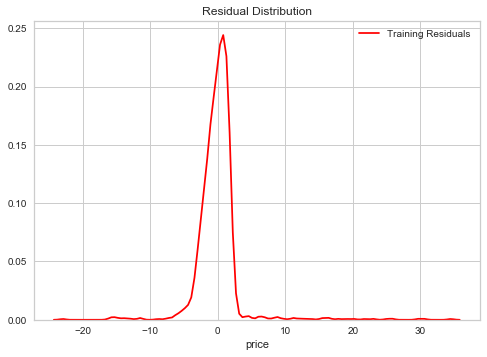

In [298]:
sns.distplot(yPredictionTrain-yTrain, hist=False, color='red', label='Training Residuals')
# sns.distplot(yPrediction-yTest, hist=False, color='blue', label='Test Residuals')
plt.title('Residual Distribution')

In [300]:
weights = linearRegressor.coef_
intercept = linearRegressor.intercept_
print("Linear Regression Weights :", weights)
print("feature order :", X.columns)
print("Linear Regression Intercept :",intercept)

Linear Regression Weights : [ 1.40602998e-03  5.15996349e+00 -5.40651916e+00 -5.37858620e+00
  1.10669825e+01  2.96955313e-01 -5.78832488e-01 -8.30986535e+00
  4.55287574e-01  1.18342278e+00  3.26844754e+00  1.92220077e+00
  9.09487345e-01  5.71019354e-01]
feature order : Index(['tmv', 'category_grouped', 'demand_supply_ratio', 'price',
       'category_compact', 'category_midsize', 'category_suv',
       'category_upscale', 'category_van', 'weekdays_Friday',
       'weekdays_Monday', 'weekdays_Saturday', 'weekdays_Sunday',
       'weekdays_Thursday', 'weekdays_Tuesday', 'weekdays_Wednesday'],
      dtype='object')
Linear Regression Intercept : -3.784347374381923


In [303]:
np.dot(np.array(weights),np.array(xTrain.iloc[1])) + intercept

62.249604693185205

In [302]:
linearRegressor.predict(np.array([xTrain.iloc[1]]))

array([62.24960469])

In [304]:
xTrain.head()

,tmv,demand_supply_ratio,category_compact,category_midsize,category_suv,category_upscale,category_van,weekdays_Friday,weekdays_Monday,weekdays_Saturday,weekdays_Sunday,weekdays_Thursday,weekdays_Tuesday,weekdays_Wednesday
531,22008,1.466096,0,0,1,0,0,0,0,0,0,1,0,0
819,27993,5.171116,0,0,0,0,1,0,0,0,0,0,0,1
750,22008,0.951813,0,0,1,0,0,0,0,1,0,0,0,0
177,39102,5.979250,0,0,1,0,0,0,1,0,0,0,0,0
867,39102,8.067818,0,0,1,0,0,1,0,0,0,0,0,0


## Recommendation function

(Write a function that takes the properties of the listing and returns a price here.)      
We got the weights and intercept of the linear regression model and transformed the train data in required format to give the prediction of price which is going to maximize the profit.    

This function can be deployed as a rest API where weights and intercept data can be taken from a file or hardcode.

In [306]:
def predict(weights, intercept, inputData):
    """Function to Predict the price of the Input Data by W.X + intercept

    Args:
        weights (List): The weights of Linear regression Model.
        intercept (Int): The intercept of Linear regression Model.
        inputData (List or pd.Series): The Input Data in raw format.

    Returns:
        Int: returns the predicted price.
    """
    
    inputDataFormat = ['vehicle_id', 'date', 'is_booked', 'tmv', 'category_grouped',
       'demand_supply_ratio']
    featureVecFormat = ['tmv', 'demand_supply_ratio', 'category_compact',
       'category_midsize', 'category_suv', 'category_upscale', 'category_van',
       'weekdays_Friday', 'weekdays_Monday', 'weekdays_Saturday',
       'weekdays_Sunday', 'weekdays_Thursday', 'weekdays_Tuesday',
       'weekdays_Wednesday']
    
#     Numerical or Boolean features
    numericalFeatures = ['tmv', 'demand_supply_ratio'] 

#     get Weekday from date
    weekday = datetime.strptime(inputData[1], '%Y-%m-%d').strftime("%A")
    
#     Initialize value of feature vec with 0
    featureVecMap = dict(zip(featureVecFormat, [0] * len(featureVecFormat)))
#     Convert input to dict
    inputDataMap = dict(zip(inputDataFormat, inputData))
    
#     Set numerical values
    for feature in numericalFeatures:
        featureVecMap[feature] = inputDataMap[feature]
    
#     set present categorical values to 1 
    featureVecMap['weekdays_'+weekday] = 1
    featureVecMap['category_'+inputDataMap['category_grouped']] = 1
      
#     get feature vector in form of list
    featureVec = list(featureVecMap.values())
    
    weights = np.array(weights)
    featureVec = np.array(featureVec)
    
    return np.dot(weights, featureVec) + intercept

In [309]:
predict(weights, intercept, df.iloc[1])

73.35256244732686

In [310]:
df.head()

,vehicle_id,date,is_booked,tmv,category_grouped,demand_supply_ratio,price,weekday
0,333483,2018-05-25,0,14569,midsize,1.902318,30.0,Friday
1,304273,2018-05-12,1,4201,compact,14.622831,39.0,Saturday
2,298081,2018-04-07,1,5724,midsize,8.659708,24.0,Saturday
3,406331,2018-12-31,1,39102,suv,13.570390,121.0,Monday
4,456223,2018-08-09,0,9666,midsize,1.297453,42.0,Thursday


## Measuring business impact

(Tell us how you'd gauge the success/business impact of the suggested price.)

The primary motive of optimizing the price is to get the car booked, so that even the lender and the company both can make profit.       
So how are we going to measure if the suggested price is making the impact?    
Answer = A/B Testing.        

#### Steps for A/B Testing:     
- Deploy this model in production(challenger) in tandem with existing one(control) and divert the traffic randomly to both the models and get the data indicating the profit(mean over few days or hours) which was made by both the set.    
- formulate a null hypothesis saying  H<sub>0</sub>: mean(profit)<sub>challenger</sub> - mean(profit)<sub>control</sub> > 0,     meaning mean profit of challenger is higher than that of control. Alternate Hypothesis is opposite of null hypothesis    
- Decide on the significance level and use two sample t test and get the P-value.     
- if P-value is less than the significance level then we reject the null hypothesis and vice versa.     
- in this case if the P-value satisfies the criteria to accept the null hypothesis then we can say that this new model is better than the current one.    
- we also take the 95% Confidence Interval to check if this result was not a fluke.      

In this way we can say that the new model is better than the current one.